# 不同迟滞类型下跟驰模型参数变化影响

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()

In [3]:
from trasim_simplified.core.kinematics.cfm import get_cf_equilibrium, get_cf_func
from trasim_simplified.core.constant import CFM

cf_name = CFM.IDM
cf_e = get_cf_equilibrium(cf_name)
cf_func = get_cf_func(cf_name)
param_names = ["s0", "v0", "T", "omega", "d", "delta"]
# param_names = ["k1", "k2", "thw", "s0"]

In [4]:
df_param_merge = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\df_param_hysteresis_merge" + f"_{cf_name}.pkl")
df_param_merge

,s0,v0,T,omega,d,delta,Pair_ID,ObjV,dec_vs,acc_vs,...,ori_acc_t,ori_dec_avg_acc,ori_acc_avg_acc,ori_dec_avg_speed,ori_acc_avg_speed,ori_min_speed,ori_max_speed,ori_dv,ori_dec_init_gap,ori_acc_init_gap
0,10.000000,40.000000,0.436868,0.548210,10.000000,10.0,10,0.863981,4.069852,8.306854,...,12.6,0.543461,0.370933,14.598033,12.777163,11.868679,16.542439,4.673760,18.02282,9.75817
1,7.737167,24.353724,0.476107,1.981402,2.087164,4.0,12,0.576711,-3.831633,0.966069,...,12.3,1.032674,0.436578,13.648202,13.694839,12.255392,17.625296,5.369904,24.43186,14.62949
2,10.000000,40.000000,1.109293,0.605000,0.407477,10.0,14,1.388066,10.296498,-0.832213,...,9.1,0.441620,0.499855,11.912428,12.366062,10.667971,15.216652,4.548681,11.20780,17.23278
3,6.811732,17.958565,0.733120,2.752649,10.000000,7.0,15,0.543265,1.627360,1.074134,...,13.4,0.702557,0.382736,11.892219,11.976463,9.859236,14.987903,5.128667,17.06087,11.72078
4,0.100000,17.043753,0.805630,1.015823,9.997592,6.0,17,0.668795,2.629436,2.638064,...,13.7,0.858664,0.357254,11.951466,11.941935,10.536007,15.430390,4.894383,11.98504,6.79674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,5.767894,10.000000,0.379805,1.382309,9.999943,2.0,6569,0.641105,1.742577,7.768757,...,6.2,0.495437,0.551373,5.130519,2.075566,2.962204,6.380716,3.418512,9.36924,4.23581
686,10.000000,40.000000,0.525731,0.771206,10.000000,10.0,6597,1.838980,3.107848,8.960103,...,8.6,0.621826,0.469985,6.939233,5.608123,4.795784,8.837655,4.041871,12.03472,9.17662
687,5.596684,10.007324,0.590291,1.280191,3.240674,4.0,6599,0.277605,0.958386,3.489490,...,8.3,0.908000,0.525109,3.924564,2.622705,1.577744,5.936146,4.358402,10.91062,5.10875
688,2.435371,25.120707,2.259007,1.832077,0.513617,2.0,6603,0.952197,-1.609772,-0.536856,...,10.9,0.321057,0.253311,4.605426,3.915928,4.560034,7.321128,2.761094,19.32218,9.86333


# 选取每个迟滞类型下的代表性轨迹

In [4]:
from trasim_simplified.util.tools import load_from_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix

# 读取轨迹
traj_s_full_ori: dict[str, dict] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\ori_dec_acc_traj_s.pkl")
traj_s_cut_pos = {pair_id: len(df_pair) for pair_id, df_pair in traj_s_full_ori["dec"].items()}

traj_s_full: dict[str, pd.DataFrame] = {pair_id: pd.concat([df_pair, traj_s_full_ori["acc"][pair_id]]) for pair_id, df_pair in traj_s_full_ori["dec"].items()}
obs_x_s = {k: traj_s_full[k][TI.x] for k in traj_s_full.keys()}
obs_v_s = {k: traj_s_full[k][TI.v] for k in traj_s_full.keys()}
obs_lx_s = {k: traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()}
obs_lv_s = {k: traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()}

traj_s_full_clb: dict[str, dict] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_traj_s" + f"_{cf_name}.pkl")
temp: dict[str, pd.DataFrame] = {pair_id: pd.concat([df_pair, traj_s_full_clb["acc"][pair_id]]) for pair_id, df_pair in traj_s_full_clb["dec"].items()}
clb_x_s = {k: temp[k][TI.x] for k in temp.keys()}
clb_v_s = {k: temp[k][TI.v] for k in temp.keys()}

leaderL_s = {k: traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()}
id_s = [k for k in traj_s_full.keys()]
print(len(id_s))

262


In [7]:
opti_ids = {"dec_neg_acc_neg": 0, "dec_pos_acc_neg": 0, "dec_pos_acc_pos": 0, "dec_neg_acc_pos": 0}

def get_opti_id(hys_type):
    temp: pd.DataFrame = df_param_merge[df_param_merge["hys_type"] == hys_type]
    if cf_name == CFM.IDM:
        temp = temp[temp["v0"] > 20]
    # 选取10%分位数下有最好ObjV的轨迹对id
    percentile_value = temp["ObjV"].quantile(0.1)
    # 提取百分位以下的数据
    temp = temp[temp['ObjV'] <= percentile_value]
    target_id = temp.loc[(temp["dec_vs"].abs() + temp["acc_vs"].abs()).idxmax()]["Pair_ID"]
    return target_id

for hys_type in opti_ids.keys():
    opti_ids[hys_type] = get_opti_id(hys_type)

opti_ids

{'dec_neg_acc_neg': 920,
 'dec_pos_acc_neg': 14319,
 'dec_pos_acc_pos': 5508,
 'dec_neg_acc_pos': 587}

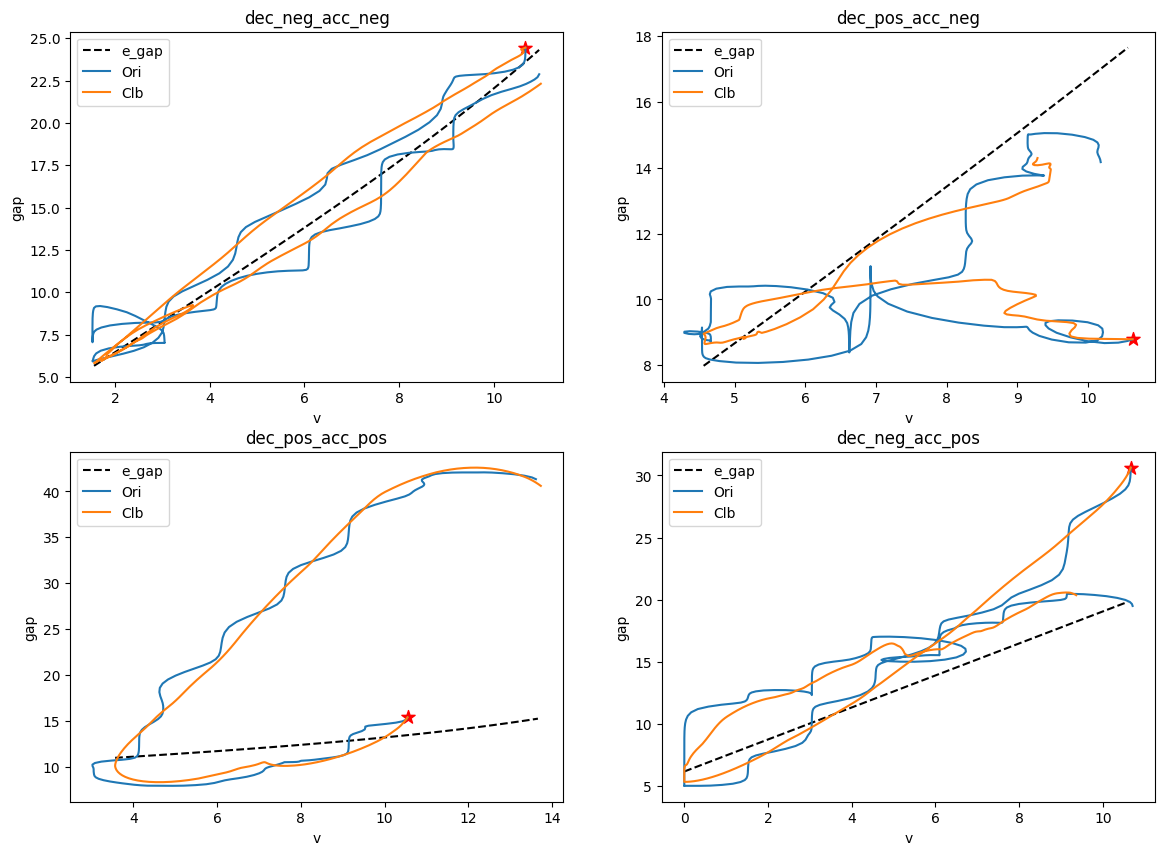

In [8]:
from trasim_simplified.core.kinematics.cfm import get_cf_default_param

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
ax = ax.flatten()
for i, (hys_type, opti_id) in enumerate(opti_ids.items()):
    v_range = np.arange(np.min(clb_v_s[opti_id]), np.max(clb_v_s[opti_id]), 0.1)
    gap_e = cf_e(**df_param_merge[df_param_merge[TI.Pair_ID] == opti_id][param_names].iloc[0].to_dict(), speed=v_range)
    ax[i].plot(v_range, gap_e, linestyle="--", color="black", label="e_gap")
    ax[i].plot(obs_v_s[opti_id], obs_lx_s[opti_id] - obs_x_s[opti_id] - leaderL_s[opti_id],  label="Ori")
    ax[i].set_title(hys_type)
    ax[i].plot(clb_v_s[opti_id], obs_lx_s[opti_id] - clb_x_s[opti_id] - leaderL_s[opti_id], label="Clb")
    ax[i].scatter(clb_v_s[opti_id].iloc[0], (obs_lx_s[opti_id] - obs_x_s[opti_id] - leaderL_s[opti_id]).iloc[0], s=100, marker="*", color="r")
    ax[i].set_xlabel("v")
    ax[i].set_ylabel("gap")
    ax[i].legend()

plt.savefig(r"E:\PyProject\car-following-model-test\tests\data\hys_type_sv" + f"_{cf_name}.png")

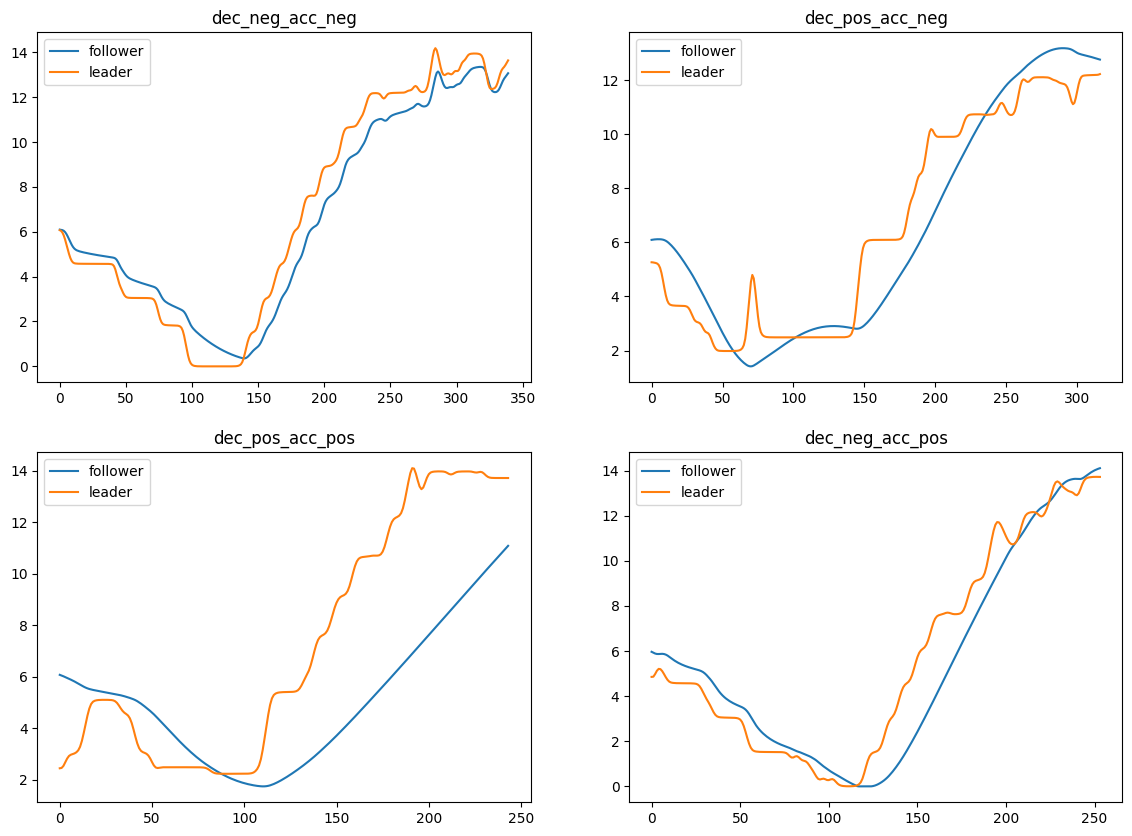

In [90]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
ax = ax.flatten()
for i, (hys_type, opti_id) in enumerate(opti_ids.items()):
    ax[i].plot(range(len(obs_v_s[opti_id])), clb_v_s[opti_id], label="follower")
    ax[i].plot(range(len(obs_v_s[opti_id])), obs_lv_s[opti_id], label="leader")
    ax[i].set_title(hys_type)
    ax[i].legend()

E:\PyProject\car-following-model-test\trasim_simplified\util\hysteresis\intensity.py:74: RuntimeWarning: invalid value encountered in scalar divide
  "dec_ts": dec_delta_s / len(dec_s), "acc_ts": acc_delta_s / len(acc_s),
E:\PyProject\car-following-model-test\trasim_simplified\util\hysteresis\intensity.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  "acc_avg_acc": (max_speed - min_speed) / (len(acc_v) * 0.1),
E:\PyProject\process-code-test\venv-old\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\PyProject\process-code-test\venv-old\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


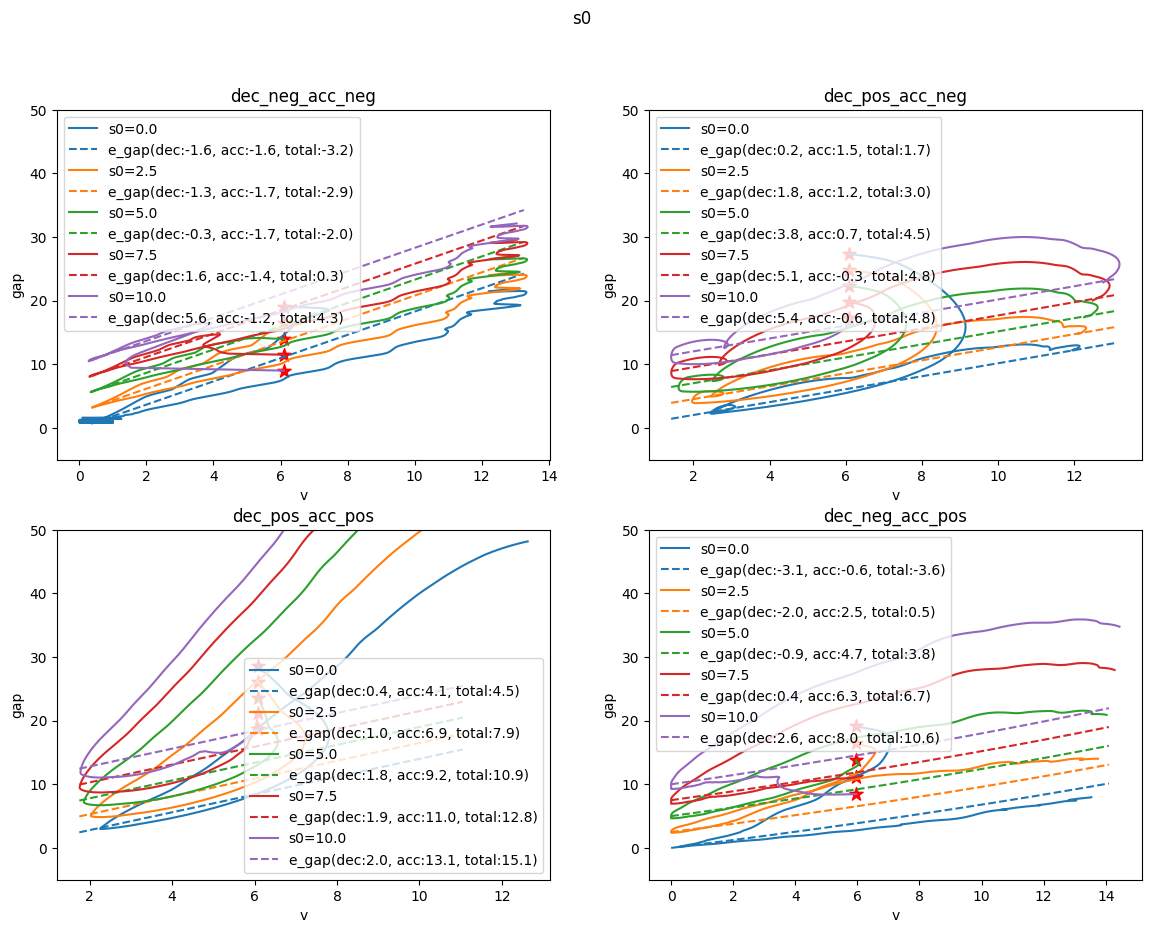

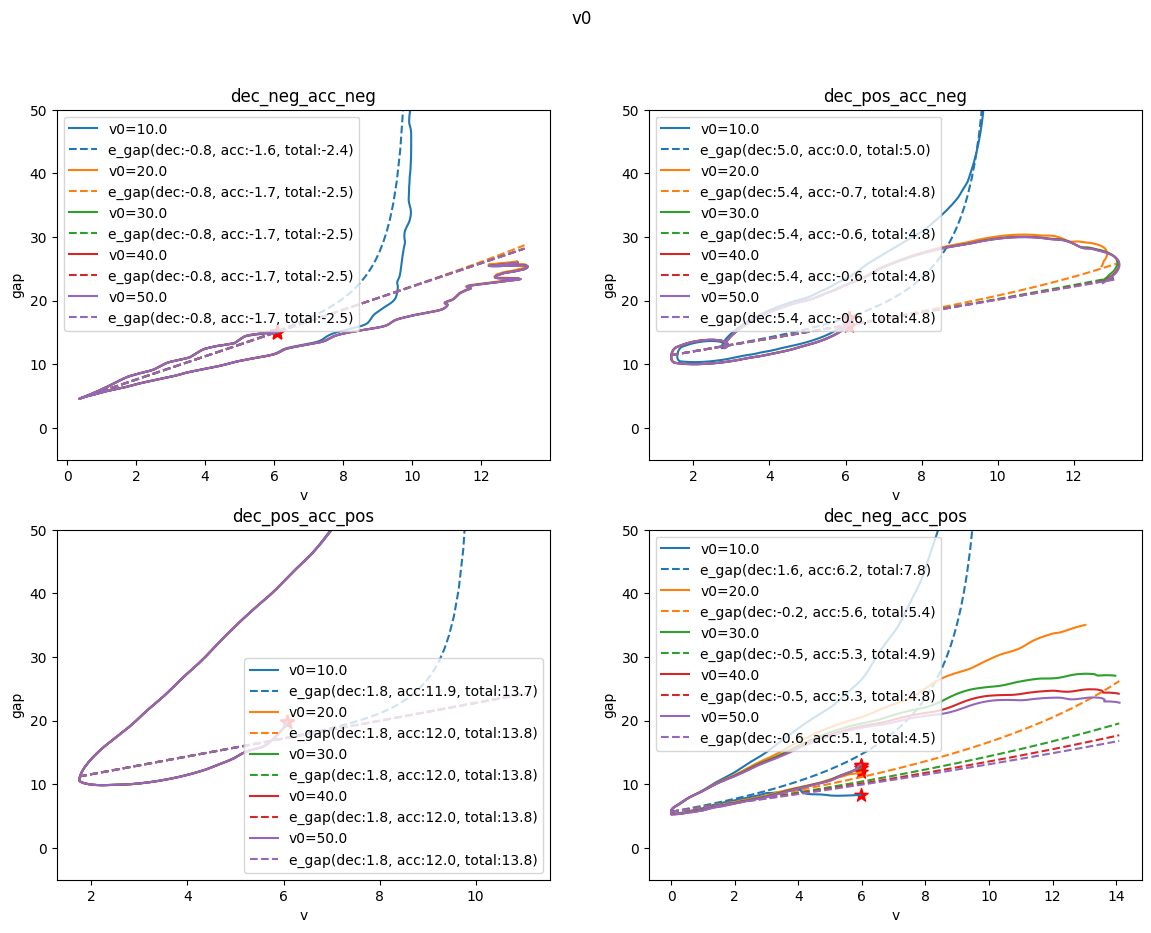

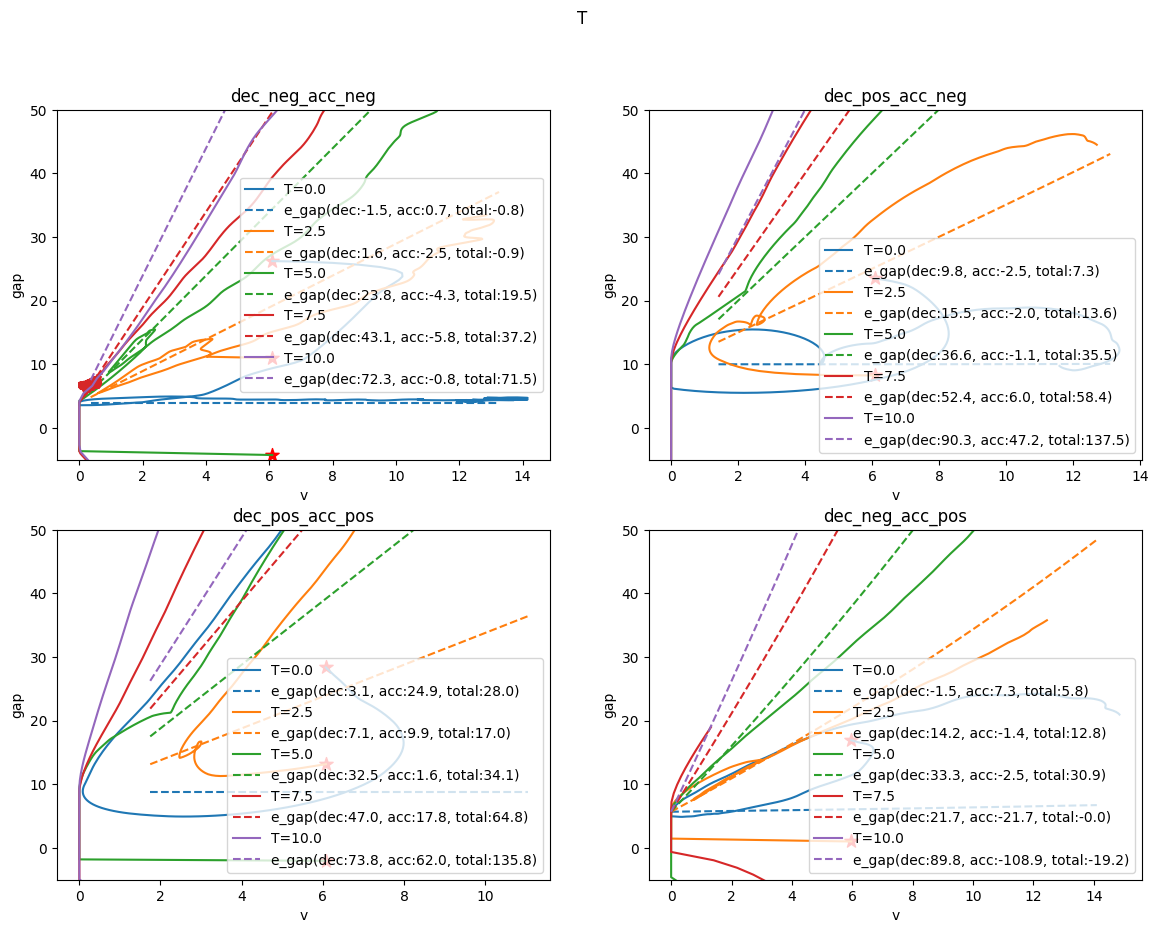

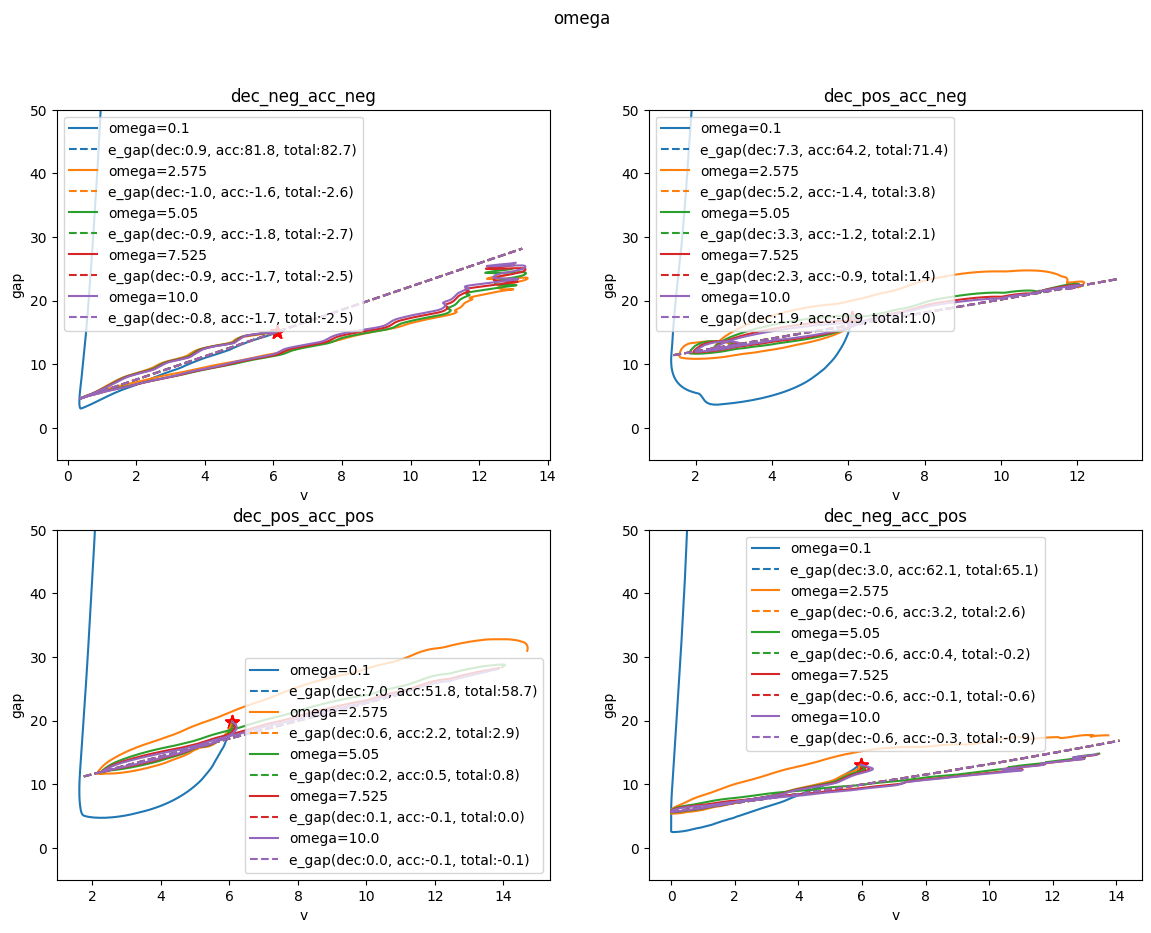

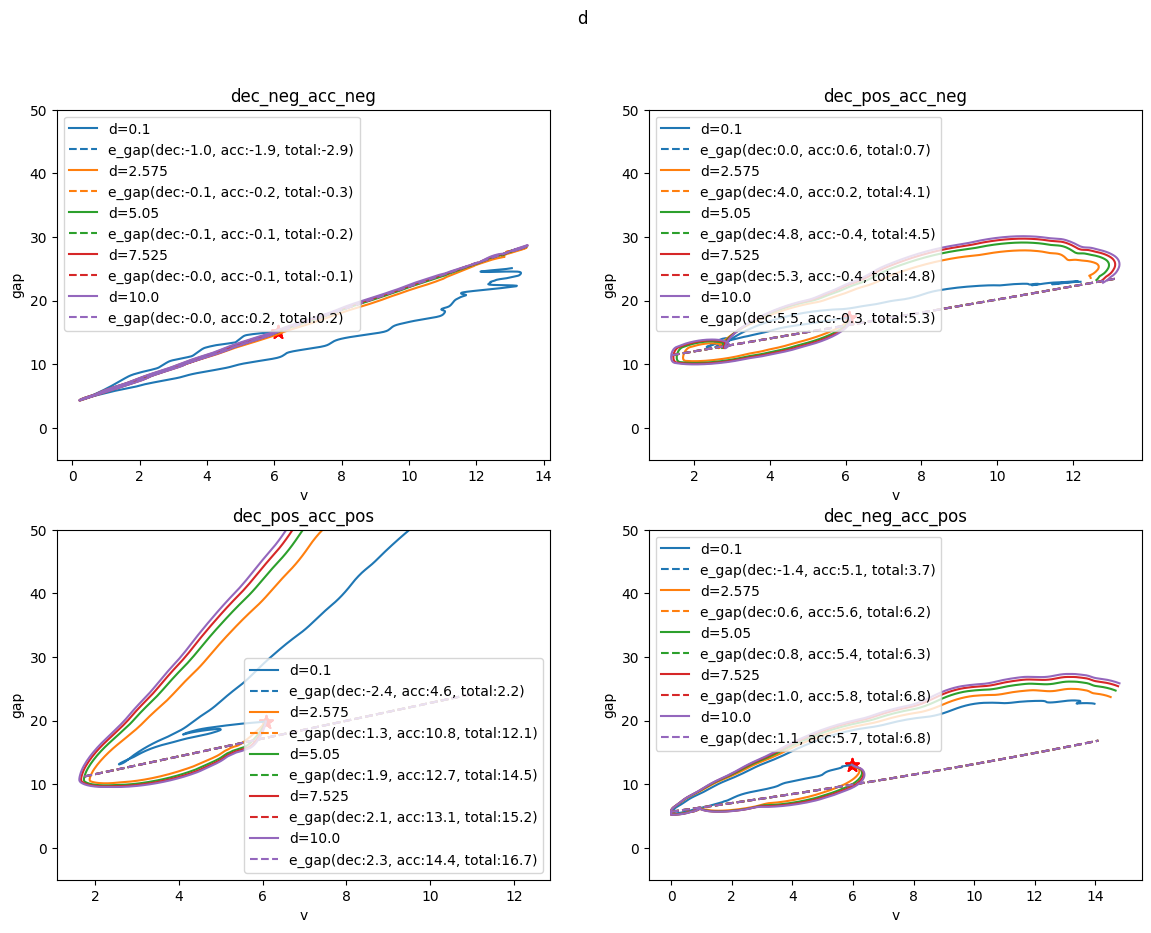

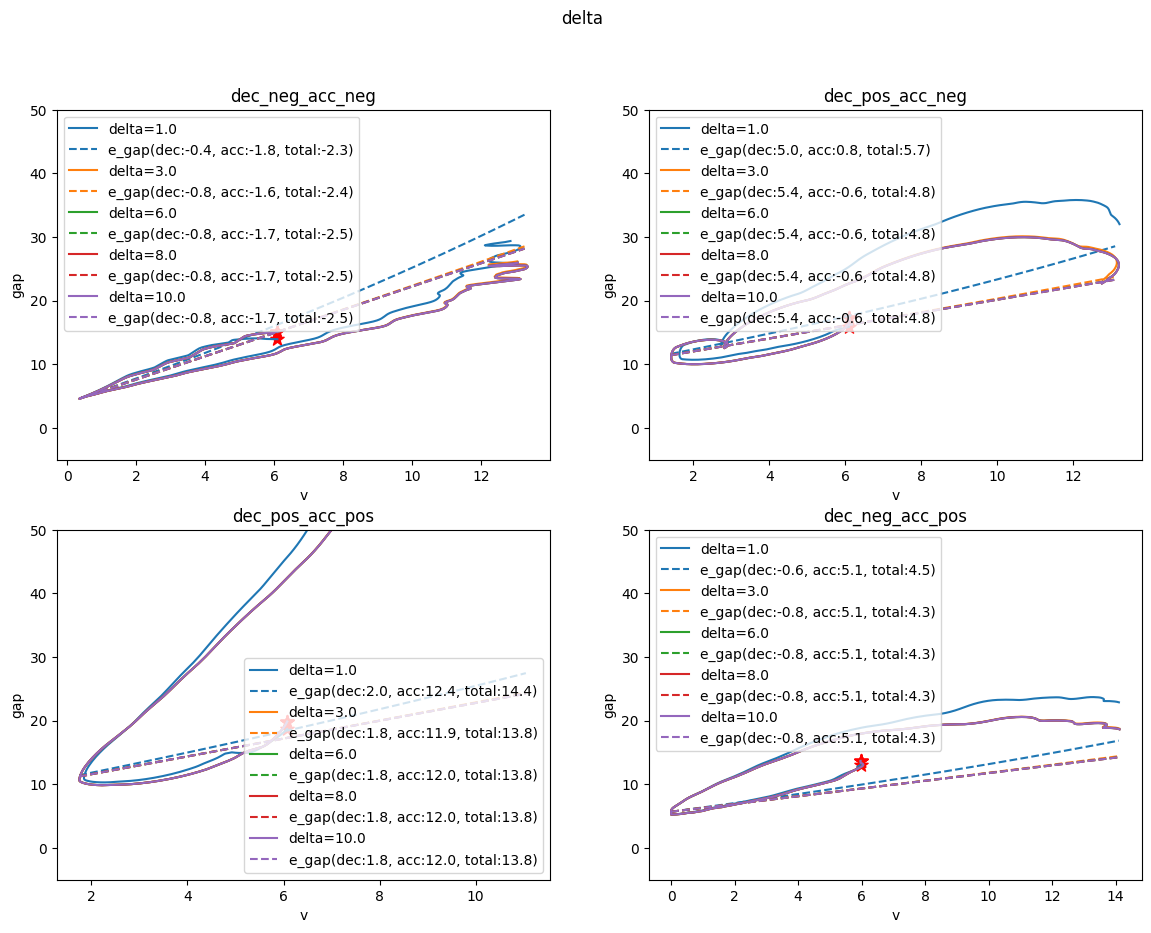

In [94]:
from trasim_simplified.util.hysteresis.intensity import cal_sv_intensity
from trasim_simplified.util.calibrate.follow_sim import simulation
from trasim_simplified.util.calibrate.clb_cf_model import cf_param_ranges, cf_param_types

for param_name in param_names:
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    ax = ax.flatten()
    for i, (hys_type, opti_id) in enumerate(opti_ids.items()):
        param_dict = df_param_merge[df_param_merge[TI.Pair_ID] == opti_id][param_names].iloc[0].to_dict()
        cf_param_range = np.linspace(cf_param_ranges[cf_name][param_name][0], cf_param_ranges[cf_name][param_name][1], 5)
        if cf_param_types[cf_name][param_name] == 1:
            cf_param_range = np.round(cf_param_range)


        ori_e_gap = cf_e(**param_dict, speed=obs_v_s[opti_id].iloc[0])
        for value in cf_param_range:
            param_dict.update({param_name: value})
            
            current_e_gap = cf_e(**param_dict, speed=obs_v_s[opti_id].iloc[0])
            sim_pos, sim_speed, sim_acc, sim_cf_acc = simulation(cf_func, obs_x_s[opti_id].iloc[0] + current_e_gap - ori_e_gap, obs_v_s[opti_id].iloc[0], obs_lx_s[opti_id], obs_lv_s[opti_id], param_dict, 0.1, leaderL_s[opti_id])
            sim_pos = np.array(sim_pos)
            sim_speed = np.array(sim_speed)
            
            # 计算迟滞强度
            result = cal_sv_intensity(
                obs_lx_s[opti_id].to_numpy()[: traj_s_cut_pos[opti_id]] - sim_pos[: traj_s_cut_pos[opti_id]] - leaderL_s[opti_id],
                sim_speed[: traj_s_cut_pos[opti_id]],
                obs_lx_s[opti_id].to_numpy()[traj_s_cut_pos[opti_id]: ] - sim_pos[traj_s_cut_pos[opti_id]: ] - leaderL_s[opti_id],
                sim_speed[traj_s_cut_pos[opti_id]: ],
                cf_e, param_dict)

            temp: list[plt.Line2D] = ax[i].plot(sim_speed, obs_lx_s[opti_id] - np.array(sim_pos) - leaderL_s[opti_id], label=f"{param_name}={value}")

            ax[i].scatter(sim_speed[0], (obs_lx_s[opti_id] - sim_pos - leaderL_s[opti_id]).iloc[0], s=100, marker="*", color="r")
            
            ax[i].set_title(hys_type)
            v_range = np.arange(np.min(clb_v_s[opti_id]), np.max(clb_v_s[opti_id]), 0.1)
            gap_e = cf_e(**param_dict, speed=v_range)
            ax[i].plot(v_range, gap_e, linestyle="--", color=temp[-1].get_color(), label=f"e_gap(dec:{result['dec_vs']:.1f}, acc:{result['acc_vs']:.1f}, total:{result['total_vs']:.1f})")

            

            ax[i].legend()
            ax[i].set_xlabel("v")
            ax[i].set_ylabel("gap")
            
            ax[i].set_ylim(-5, 50)
            
            fig.suptitle(param_name)
    plt.savefig(r"E:\PyProject\car-following-model-test\tests\data\hys_type_param_change_" + param_name + f"_{cf_name}.png")